In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dependencies
import pandas as pd
from string import punctuation
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import time
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [ ]:
# Set up paths
DATA_FILEPATH = "/content/drive/MyDrive/Text Summarization/Data/Inshorts Cleaned Data.xlsx"

In [ ]:
# Download the Transformer-Network achitecture file and run it
!wget https://raw.githubusercontent.com/GargPriyanshu1112/Text-Summarization/main/transformer_architecture.ipynb

%run transformer_architecture.ipynb

--2022-09-04 10:05:01--  https://raw.githubusercontent.com/GargPriyanshu1112/Text-Summarization/main/transformer_architecture.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20602 (20K) [text/plain]
Saving to: ‘transformer_architecture.ipynb’

transformer_archite 100%[===================>]  20.12K  --.-KB/s    in 0s      

2022-09-04 10:05:01 (139 MB/s) - ‘transformer_architecture.ipynb’ saved [20602/20602]



In [ ]:
# Load in the Data
data = pd.read_excel(DATA_FILEPATH)
data.head()

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55104 entries, 0 to 55103
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Headline      55104 non-null  object        
 1   Short         55104 non-null  object        
 2   Source        55104 non-null  object        
 3   Time          55104 non-null  object        
 4   Publish Date  55104 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.1+ MB


In [ ]:
data.columns

Index(['Headline', 'Short', 'Source ', 'Time ', 'Publish Date'], dtype='object')

In [ ]:
# Remove 'Source', 'Time', 'Publish Date' columns
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)

# Set the dtype of the columns to 'str'
data = data.astype('str')

# Rename columns
data.rename(columns={'Headline': 'Summary', 'Short':'Description'}, inplace=True)
data.head()

,Summary,Description
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [ ]:
# Add `start` and `end` tags to the decoder sequences
data['Summary'] = data['Summary'].apply(lambda text: 'startseq ' + text + ' endseq')

In [ ]:
max_desc_len = max([len(sentence.split())  for sentence in data['Description']])
max_summary_len = max([len(sentence.split())  for sentence in data['Summary']])

print(f"Number of words in longest description : {max_desc_len}")
print(f"Number of words in longest summary     : {max_summary_len}")

Number of words in longest description : 67
Number of words in longest summary     : 16


# Tokenize and Pad the Sequences

In [ ]:
def get_tokenizer(texts):
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(texts)

    return tokenizer

In [ ]:
def tokenize_and_pad_texts(tokenizer, texts):
    seqs = tokenizer.texts_to_sequences(texts)
    seqs = pad_sequences(seqs, padding='post', truncating='post')

    return seqs

In [ ]:
# Get the tokenizer for descriptions
desc_tokenizer = get_tokenizer(data['Description'])

# Get the tokenizer for summaries
summary_tokenizer = get_tokenizer(data['Summary'])

In [ ]:
# Tokenize and pad the descriptions
inputs = tokenize_and_pad_texts(desc_tokenizer, data.Description)

# Tokenize and pad the summaries
targets = tokenize_and_pad_texts(summary_tokenizer, data.Summary)

In [ ]:
desc_vocab_size = len(desc_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1

print(f"Vocab size for descriptions : {desc_vocab_size}")
print(f"Vocab size for summaries    : {summary_vocab_size}")

Vocab size for descriptions : 76362
Vocab size for summaries    : 29661


# Create Dataset Pipeline

In [ ]:
BATCH_SIZE = 128

In [ ]:
def get_train_dataset(X_train, y_train):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset

In [ ]:
train_dataset = get_train_dataset(inputs, targets)

# Define Optimizer with Custom Learning Rate

In [ ]:
embedding_dim = 128

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.embedding_dim = embedding_dim
        self.embedding_dim = tf.cast(self.embedding_dim, tf.float32)

        self.warmup_steps = warmup_steps

    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(embedding_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

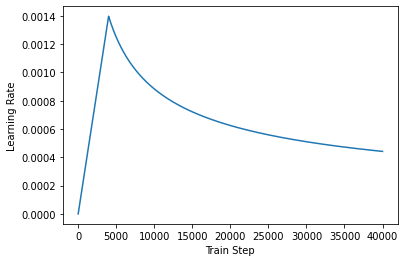

In [ ]:
# Epoch vs Learning Rate
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step");

# Define Loss Function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

# Get the Transformer Network

In [ ]:
# Hyper-parameters
num_layers = 4
num_heads = 8
fully_connected_dim = 512
input_vocab_size = desc_vocab_size
target_vocab_size = summary_vocab_size
max_positional_encoding_input = desc_vocab_size
max_positional_encoding_target = summary_vocab_size

In [ ]:
transformer = Transformer(num_layers, 
                          embedding_dim, 
                          num_heads,
                          fully_connected_dim,
                          input_vocab_size,
                          target_vocab_size,
                          max_positional_encoding_input,
                          max_positional_encoding_target)

# Establish Checkpoints

In [ ]:
checkpoint_dir = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(transformer=transformer,
                                 optimizer=optimizer)

# Create Masks

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

# Train the Model

During training, since we have access to the entire correct output translation, we don't have to generate words one at a time. We will use **Look-ahead Mask** to block out the last part of the sentence. This will mimic what the network will need to do during prediction.


In [ ]:
EPOCHS = 30

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, 
                                     tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [ ]:
for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    train_loss.reset_states()
  
    for batch, (inp, tar) in enumerate(train_dataset):
        train_step(inp, tar)
      
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print(f"Epoch {epoch+1},  Loss {(train_loss.result()):.4f}")
    print(f"Time taken for epoch {epoch+1} : {(time.time() - epoch_start_time):.1f} secs\n")

Epoch 1,  Loss 9.1676
Time taken for epoch 1 : 67.6 secs

Epoch 2,  Loss 7.1977
Time taken for epoch 2 : 53.5 secs

Epoch 3,  Loss 6.5361
Time taken for epoch 3 : 53.5 secs

Epoch 4,  Loss 5.9689
Time taken for epoch 4 : 53.5 secs

Epoch 5,  Loss 5.4983
Time taken for epoch 5 : 53.4 secs

Epoch 6,  Loss 5.0848
Time taken for epoch 6 : 53.4 secs

Epoch 7,  Loss 4.7052
Time taken for epoch 7 : 53.4 secs

Epoch 8,  Loss 4.3361
Time taken for epoch 8 : 53.4 secs

Epoch 9,  Loss 4.0313
Time taken for epoch 9 : 53.3 secs

Epoch 10,  Loss 3.7509
Time taken for epoch 10 : 54.1 secs

Epoch 11,  Loss 3.4565
Time taken for epoch 11 : 53.4 secs

Epoch 12,  Loss 3.1699
Time taken for epoch 12 : 53.4 secs

Epoch 13,  Loss 2.9156
Time taken for epoch 13 : 53.4 secs

Epoch 14,  Loss 2.6782
Time taken for epoch 14 : 53.4 secs

Epoch 15,  Loss 2.4722
Time taken for epoch 15 : 53.4 secs

Epoch 16,  Loss 2.2928
Time taken for epoch 16 : 53.4 secs

Epoch 17,  Loss 2.1305
Time taken for epoch 17 : 53.5 secs

# Inference

In [ ]:
def evaluate(desc):
    input_seq = desc_tokenizer.texts_to_sequences([desc])
    input_seq = pad_sequences(input_seq, maxlen=max_desc_len, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_seq[0], axis=0)

    decoder_input = [summary_tokenizer.word_index["startseq"]]

    output = tf.expand_dims(decoder_input, axis=0)
    
    for i in range(max_desc_len):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["endseq"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def summarize(desc):
    summarized = evaluate(desc)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    summary = summary_tokenizer.sequences_to_texts(summarized)[0]

    print(f"SUMMARY: \n  {summary}")

In [ ]:
summarize(
    "US-based private equity firm General Atlantic is in talks to invest about \
    $850 million to $900 million in Reliance Industries' digital unit Jio \
    Platforms, the Bloomberg reported. Saudi Arabia's $320 billion sovereign \
    wealth fund is reportedly also exploring a potential investment in the \
    Mukesh Ambani-led company. The 'Public Investment Fund' is looking to \
    acquire a minority stake in Jio Platforms."
)

SUMMARY: 
  firm to invest €1 billion to invest money to jio


In [ ]:
summarize(
    "South Africa registered their third straight test series win in Australia \
    by winning the second test at Hobart by an innings and 80 runs on tuesday \
    to take an unassailable 2-0 lead in the series. It was the fifth \
    consecutive defeat in as many tests for Australia who scored 85 \
    and 161 in their two innings as opposed to South Africa's 39 and 326")

SUMMARY: 
  sa wins its 2nd test against aus in aus
